# MADE: Masked Autoencoder for Distribution Estimation

This is the Keras implementation of the paper MADE: Masked Autoencoder for Distribution Estimation by Mathieu Germain, Iain Murray and Hugo Larochelle. This code borrows heavily from the original implementation by Germain, the implementation by Andrez Karpathy and finally the implementation by Brian Keng without whose amazing blog, this would not have been possible in the first place.

In [1]:
%matplotlib inline
import numpy as np
import keras
import pandas as pd
import math
import matplotlib.pyplot as plt
import random

Using TensorFlow backend.


In [0]:
import time
#import joblib
from IPython.display import display
from keras.layers import Input, Dense, Flatten, Reshape, BatchNormalization, Activation, Dropout
from keras.engine import Layer
#If needed import regularizers
from keras.initializers import RandomUniform
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Model, Sequential
from keras import metrics
from keras import backend as k
from keras.datasets import mnist
#from .tqdm_callback import TQDMCallback
#from .tqdm_notebook_callback import TQDMNotebookCallback
# import TQDM_notebook and callback
from random import randint

# Import the MNIST data

In [3]:
# First we reshape the images to convert them into a 1D array for autoregressie predictions
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])
print(X_train.shape, Y_train.shape)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])
print(X_test.shape, Y_test.shape)
# Now we normalize the values so that they lie in the range [0,1]
X_train = X_train/255.0
X_test = X_test/255.0
#print(np.min(X_train), np.max(X_test))

11493376/11490434 [==============================] - 2s 0us/step
(60000, 784) (60000,)
(10000, 784) (10000,)


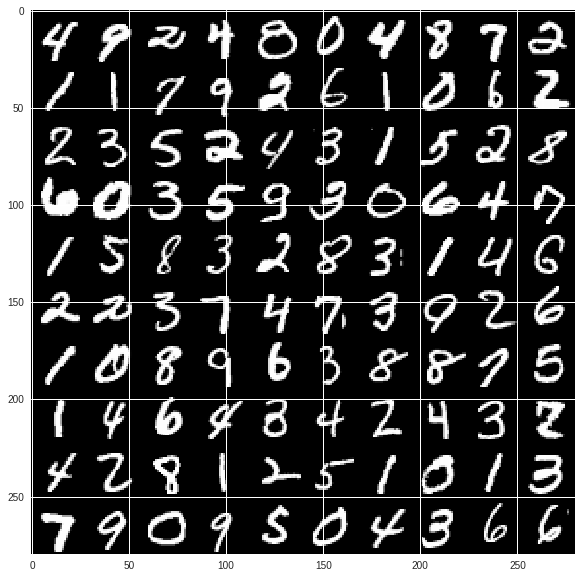

In [4]:
# Now display a mosaic of 10*10 random digits picked from
# the dataset X_train. Implementation picked up from Brian_Keng
def display_sample(X, image_size = 28, grid_size =10):
    figure = np.zeros((image_size*grid_size, image_size*grid_size))
    
    for i in range(grid_size):
        for j in range(grid_size):
            index = randint(0,X.shape[0])
            figure[i*image_size:(i+1)*image_size,j*image_size:(j+1)*image_size] = X[index].reshape(image_size,image_size)
            
    plt.figure(figsize = (grid_size, grid_size)) 
    plt.imshow(figure, cmap = 'Greys_r')
    plt.show()
    
display_sample(X_train)    

In [0]:
# We will have a mask generator obect which returns the masks between all the layers
# Further we wll have a custom masking layer which is nothing but a mask applied to a keras.Dense layer
from keras.models import Model
from keras.layers import Input, Dense
from keras.layers import initializers
from keras.layers import activations
from keras.layers import regularizers
from keras.layers import constraints
from keras.engine import InputSpec
from keras.engine import Layer
import numpy as np
import tensorflow as tf

In [0]:
def mask_generator(n_dim_inp, hidden_layers, random_input_order, seed):
    m = {}
    rng = np.random.RandomState(seed)
    if random_input_order == False:
        m[-1] = np.arange(n_dim_inp)
    else:
        m[-1] = rng.permutation(n_dim_inp)        
    for i in range(len(hidden_layers)):
        m[i] = rng.randint(m[i-1].min(), n_dim_inp -1, size = hidden_layers[i])
            
    masks = [tf.convert_to_tensor((m[l-1][:, None] <= m[l][None,:]), dtype=np.float32) for l in range(len(hidden_layers))]
    L = len(hidden_layers)
    masks.append(tf.convert_to_tensor((m[L-1][:, None] < m[-1][None, :]), dtype = np.float32))
    #The last mask is the direct connection between the input and the output layer
    
    #for j in range(len(masks)):
        #masks[j].astype(np.float32)
        
    return masks
    

In [0]:
#The custom masking layer
# mask represents the mask associated with the current layer 
# direct_mask represents the direct mask between the input and the output layer

class custom_masking(Layer):
    def __init__(self, units, mask, 
                 #direct_mask = None,
                 random_input_order = False, 
                 #is_output = False,
                 activation='relu',
                 use_bias=False,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 kernel_regularizer=None,
                 bias_regularizer=None,
                 activity_regularizer=None,
                 kernel_constraint=None,
                 bias_constraint=None,
                 **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(custom_masking, self).__init__(**kwargs)
        # Note that the input shape can also be inferred from the shape of prev_arr
        self.units = units
        self.mask = mask
        #self.direct_mask = direct_mask
        self.random_input_order = random_input_order
        #self.is_output = is_output
        self.activation = activations.get(activation)
        self.use_bias = use_bias
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)
        self.kernel_regularizer = regularizers.get(kernel_regularizer)
        self.bias_regularizer = regularizers.get(bias_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)
        self.kernel_constraint = constraints.get(kernel_constraint)
        self.bias_constraint = constraints.get(bias_constraint)
        self.input_spec = InputSpec(min_ndim=2)
    
    def build(self, input_shape):
        ## Write the code
        ## Does the direct connection between the inputs and outputs use a bias term?
        ## Same as keras.Dense
        assert len(input_shape) >= 2
        input_dim = input_shape[-1]
        
        self.kernel = self.add_weight(shape=(input_dim, self.units),
                                      initializer=self.kernel_initializer,
                                      name='kernel',
                                      regularizer=self.kernel_regularizer,
                                      constraint=self.kernel_constraint)
        if self.use_bias:
            self.bias = self.add_weight(shape=(self.units,),
                                        initializer=self.bias_initializer,
                                        name='bias',
                                        regularizer=self.bias_regularizer,
                                        constraint=self.bias_constraint)
        else:
            self.bias = None
        
        
        #if self.is_output:
            #length = len(self.direct_mask)
            #self.direct_kernel = self.add_weight(shape = (length, length), 
                                                #initializer = self.kernel_initializer,
                                                #name = 'direct_kernel',regularizer = self.kernel_regularizer,
                                                #constraint = self.kernel_constraint)
        
        self.input_spec = InputSpec(min_ndim=2, axes={-1: input_dim})
        self.built = True

    
    def call(self, inputs):
        ## Modified keras.Dense to account for the mask
        pre_output = self.kernel*self.mask
        output = k.dot(inputs, pre_output)
        if self.use_bias:
            output = k.bias_add(output, self.bias, data_format = 'channels_last')    
        if self.activation is not None:
            output = self.activation(output)
            return output
        
        #elif self.is_output:
        #pre_direct_output = 
            
    
    def compute_output_shape(self, input_shape):
           ##Same as keras.Dense
        assert input_shape and len(input_shape) >= 2
        assert input_shape[-1]
        output_shape = list(input_shape)
        output_shape[-1] = self.units
        return tuple(output_shape)   

In [0]:
# Finally, we have the MADE object
class MADE(object):
        def __init__(self, n_in, hidden_sizes, n_out, random_input_order):
            self.n_in = n_in
            self.hidden_sizes = hidden_sizes
            self.n_out = n_out
            self.random_input_order = random_input_order
            seed1 = np.random.randint(0,10)
            self.mask = mask_generator(self.n_in, self.hidden_sizes, self.random_input_order, seed=seed1)
        
        def build_model(self):
            a = Input(shape = (self.n_in,))
            x_layers = []
            #len(size_array)
            for i in range(len(self.hidden_sizes)):
                if i == 0:
                    x_layers.append(custom_masking(self.hidden_sizes[i], mask = self.mask[i])(a)) #activation is relu
                else:
                    x_layers.append(custom_masking(self.hidden_sizes[i], mask = self.mask[i])(x_layers[i-1]))
            
            #Now write the output layer, output layer's activation is sigmoid. 
            # The output mask is already present in self.mask, need the direct mask
            L = len(self.hidden_sizes)    
            output_layer = custom_masking(self.n_in, mask = self.mask[-1], activation='sigmoid')(x_layers[-1])
            x_layers.append(output_layer)
            #direct_connect_mask =     
            #direct_connect = 
            #add the two layers
            #apply activation
            
            self.model = Model(inputs = a, outputs = x_layers[-1])  
            return self.model
            
        def summary(self):
            return self.model.summary()

In [0]:
# This was meant only for test purposes
#from keras import backend as k
#test = MADE(22, [9, 6, 8], 22, random_input_order=False)
#test.build_model()
#test.summary()
#print(len(X_train[0]))

In [0]:
def recons_loss(x, x_decoded_mean):
    x = k.flatten(x)
    x_decoded_mean = k.flatten(x_decoded_mean)
    xent_loss = len(X_train[1]) * metrics.binary_crossentropy(x, x_decoded_mean)
    return xent_loss

In [11]:
k.set_learning_phase(1)

temp = MADE(len(X_train[0]), [651, 312], len(X_train[0]), random_input_order=False)
model = temp.build_model()
optimizer = Adam(lr=0.0005)
model.compile(optimizer=optimizer, loss=recons_loss)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
custom_masking_1 (custom_mas (None, 651)               510384    
_________________________________________________________________
custom_masking_2 (custom_mas (None, 312)               203112    
_________________________________________________________________
custom_masking_3 (custom_mas (None, 784)               244608    
Total params: 958,104
Trainable params: 958,104
Non-trainable params: 0
_________________________________________________________________


In [12]:
start = time.time()

learning_rate = 0.0005

history = model.fit(
    X_train, X_train,
    batch_size=500,
    epochs=250,
    validation_data=(X_test, X_test),
)

k.set_learning_phase(0)

done = time.time()
elapsed = done - start
print("Elapsed: ", elapsed)

Train on 60000 samples, validate on 10000 samples
Epoch 1/250
60000/60000 [==============================] - 3s 43us/step - loss: 386.7059 - val_loss: 318.2703
Epoch 2/250
60000/60000 [==============================] - 2s 25us/step - loss: 305.5414 - val_loss: 293.4971
Epoch 3/250
60000/60000 [==============================] - 2s 25us/step - loss: 287.1273 - val_loss: 278.6146
Epoch 4/250
60000/60000 [==============================] - 2s 25us/step - loss: 274.1801 - val_loss: 267.4488
Epoch 5/250
60000/60000 [==============================] - 1s 25us/step - loss: 264.1164 - val_loss: 258.4733
Epoch 6/250
60000/60000 [==============================] - 2s 25us/step - loss: 255.9148 - val_loss: 251.0498
Epoch 7/250
60000/60000 [==============================] - 2s 25us/step - loss: 249.0974 - val_loss: 244.8154
Epoch 8/250
60000/60000 [==============================] - 1s 25us/step - loss: 243.2208 - val_loss: 239.2417
Epoch 9/250
60000/60000 [==============================] - 2s 25us/ste

,loss,val_loss
count,250.000000,250.000000
mean,189.930983,189.667672
std,20.949333,17.357804
min,180.769951,181.995934
0%,180.769951,181.995934
25%,181.725470,182.644059
50%,183.391768,183.845658
75%,187.934127,187.625607
95%,222.170077,219.412948
99.9%,366.495939,312.101797


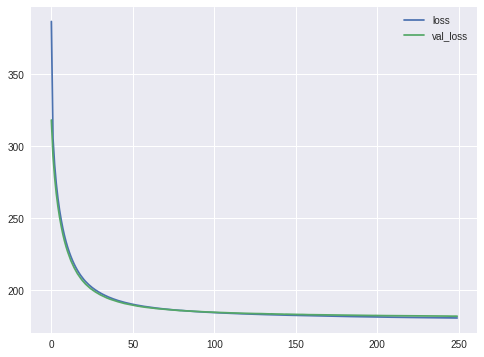

In [15]:
df = pd.DataFrame(history.history)
display(df.describe(percentiles=[0.25 * i for i in range(4)] + [0.95, 0.999]))
df.plot(figsize=(8, 6))